In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import ( confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,
                              roc_curve,roc_auc_score,classification_report
)
import warnings
warnings.filterwarnings('ignore')

In [6]:
df =pd.read_csv('fake_news_dataset.csv')
target='Is_Fake'
feature_cols=[c for c in df.columns if c != target]
x = df[feature_cols]
y = df[target]
print('Shape',df.shape)
print('Class distribution:');print(y.value_counts())
print('\nFeatures:',feature_cols)

Shape (1000, 6)
Class distribution:
0    584
1    416
Name: Is_Fake, dtype: int64

Features: ['Sensationalism_Score', 'Source_Trust_Rating', 'Exclamation_Count', 'Word_Count', 'Author_Verified']


In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled= scaler.transform(x_test)
print('Train:', x_train.shape[0],'Test:',x_test.shape[0])

Train: 750 Test: 250


In [19]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42,k_neighbors=5)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)
print('After SMOTE - Train class distribution:')
print(pd.Series(y_train_smote).value_counts())

After SMOTE - Train class distribution:
0    438
1    438
Name: Is_Fake, dtype: int64


In [20]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight('balanced',classes=classes,y=y_train)
class_weights = dict(zip(classes,weights))
print('Class weights (balanced):',class_weights)


Class weights (balanced): {0: 0.8561643835616438, 1: 1.2019230769230769}


In [24]:
def evaulate(name, y_true, y_pred, y_proba = None):
    print('=')
    print(name)
    print('=' * 10)
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion_matrix: '); print(cm)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Real','Fake'], yticklabels = ['Real','Fake'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True');plt.xlabel('Predicted')
    plt.show()
    
    print('Accuracy: ', round(accuracy_score(y_true, y_pred), 4))
    print("Precision: ", round(precision_score(y_true, y_pred, zero_division = 0), 4))
    print("Recall: ", round(recall_score(y_true, y_pred, zero_division = 0),4))
    print('F-1 Score: ', round(f1_score(y_true, y_pred, zero_division = 0), 4))
    if y_proba is not None:
        print('ROC-AUC: ', round(roc_auc_score(y_true, y_proba), 4))
        print(classification_report(y_true, y_pred, target_names = ['Real','Fake']))
        return{'accuracy': accuracy_score(y_true, y_pred), 'precision': precision_score(y_true, y_pred, zero_division = 0),
              'recall':recall_score(y_true, y_pred, zero_division = 0),
              'f1': f1_score(y_true, y_pred, zero_division = 0),
              'roc-auc': roc_auc_score(y_true, y_proba) if y_proba is not None else None}

=
Random Forest
Confusion_matrix: 
[[128  18]
 [ 15  89]]


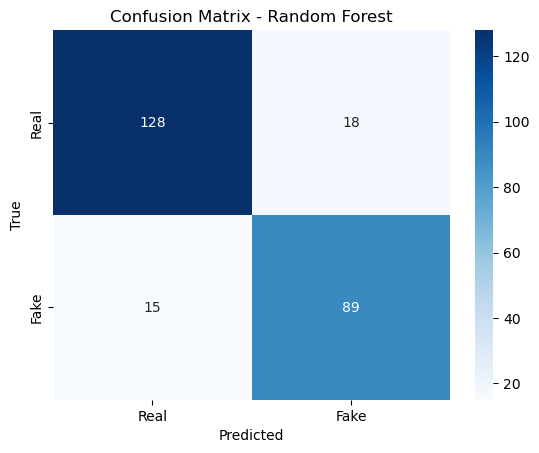

Accuracy:  0.868
Precision:  0.8318
Recall:  0.8558
F-1 Score:  0.8436
ROC-AUC:  0.9289
              precision    recall  f1-score   support

        Real       0.90      0.88      0.89       146
        Fake       0.83      0.86      0.84       104

    accuracy                           0.87       250
   macro avg       0.86      0.87      0.86       250
weighted avg       0.87      0.87      0.87       250



In [27]:
rf=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

rf.fit(x_train_smote, y_train_smote)
y_pred_rf=rf.predict(x_test_scaled)
y_proba_rf=rf.predict_proba(x_test_scaled)[:,1]
results={}
results['Random Forest (Bagging)']=evaulate('Random Forest',y_test,y_pred_rf,y_proba_rf)

=
AdaBoost
Confusion_matrix: 
[[122  24]
 [ 16  88]]


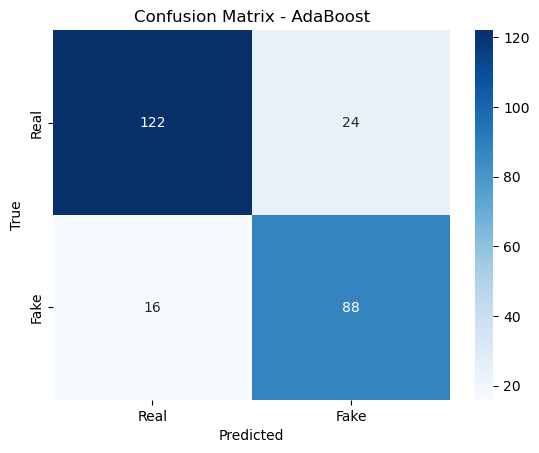

Accuracy:  0.84
Precision:  0.7857
Recall:  0.8462
F-1 Score:  0.8148
ROC-AUC:  0.9342
              precision    recall  f1-score   support

        Real       0.88      0.84      0.86       146
        Fake       0.79      0.85      0.81       104

    accuracy                           0.84       250
   macro avg       0.83      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



In [30]:
ada=AdaBoostClassifier(n_estimators=50,random_state=42)
ada.fit(x_train_smote,y_train_smote)
y_pred_ada=ada.predict(x_test_scaled)
y_proba_ada=ada.predict_proba(x_test_scaled)[:,1]
results['AdaBoost']=evaulate('AdaBoost',y_test,y_pred_ada,y_proba_ada)

=
Gradient Boosting
Confusion_matrix: 
[[125  21]
 [ 18  86]]


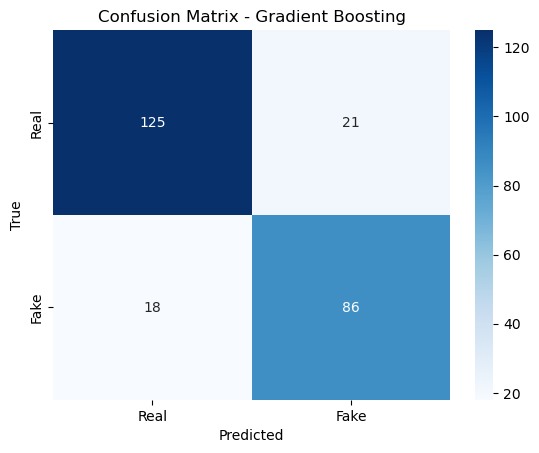

Accuracy:  0.844
Precision:  0.8037
Recall:  0.8269
F-1 Score:  0.8152
ROC-AUC:  0.9239
              precision    recall  f1-score   support

        Real       0.87      0.86      0.87       146
        Fake       0.80      0.83      0.82       104

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



In [32]:
gb=GradientBoostingClassifier(n_estimators=100,max_depth=5,random_state=42)
gb.fit(x_train_smote,y_train_smote)
y_pred_gb=gb.predict(x_test_scaled)
y_proba_gb=gb.predict_proba(x_test_scaled)[:,1]
results['Gradient Boosting']=evaulate('Gradient Boosting',y_test,y_pred_gb,y_proba_gb)


=
XGBoost
Confusion_matrix: 
[[125  21]
 [ 16  88]]


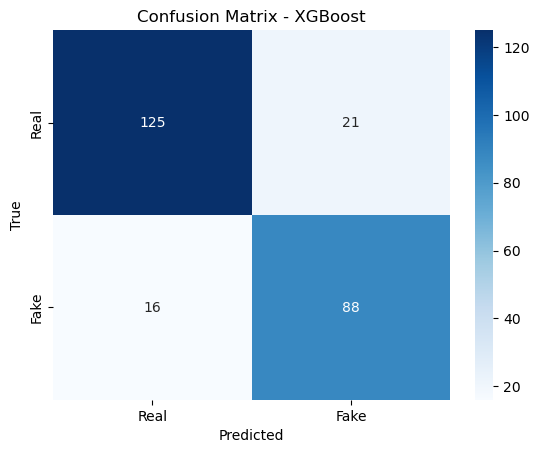

Accuracy:  0.852
Precision:  0.8073
Recall:  0.8462
F-1 Score:  0.8263
ROC-AUC:  0.9308
              precision    recall  f1-score   support

        Real       0.89      0.86      0.87       146
        Fake       0.81      0.85      0.83       104

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



In [41]:
y_proba_xgb=None
try:
    import xgboost as xgb
    xgb_clf=xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
    xgb_clf.fit(x_train_smote, y_train_smote)
    y_pred_xgb=xgb_clf.predict(x_test_scaled)
    y_proba_xgb=xgb_clf.predict_proba(x_test_scaled)[:,1]
    results['XGBoost']=evaulate('XGBoost',y_test,y_pred_xgb,y_proba_xgb)
except ImportError:
    print('XGBoost not installed run: pip install xgboost')
    results['XGBoost']=None

In [38]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

     -------------------------------------- 101.7/101.7 MB 7.4 MB/s eta 0:00:00


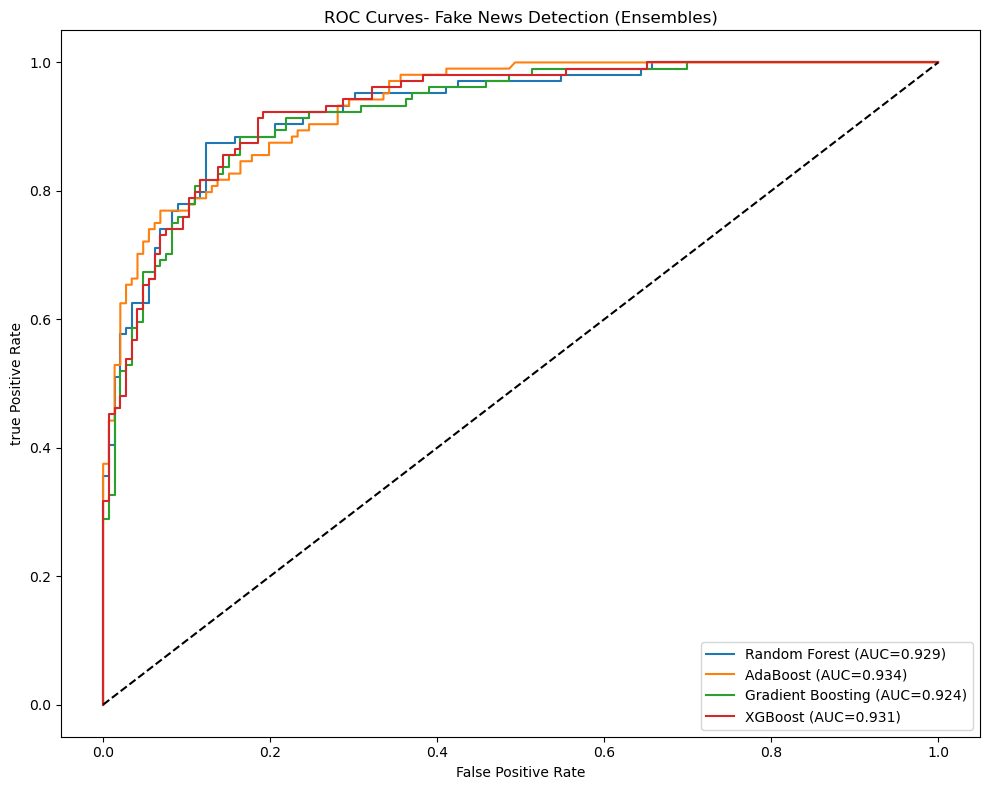

In [46]:
proba_dict={'Random Forest': y_proba_rf,'AdaBoost': y_proba_ada, 'Gradient Boosting': y_proba_gb}
if y_proba_xgb is not None:
    proba_dict['XGBoost']=y_proba_xgb
    
plt.figure(figsize=(10,8))
for name,y_proba in proba_dict.items():
    fpr,tpr,_=roc_curve(y_test, y_proba)
    auc=roc_auc_score(y_test,y_proba)
    plt.plot(fpr,tpr,label=f'{name} (AUC={auc:.3f})')

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('true Positive Rate')
plt.title('ROC Curves- Fake News Detection (Ensembles)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
